## LLM

In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm

print("Physical devices:", tf.config.list_physical_devices())
print("GPUs:", tf.config.list_physical_devices('GPU'))


Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

In [243]:
class TokenizerChar:
    def __init__(self, text):
        self.vocab = sorted(list(set(text)))
        self.vocab_size = len(self.vocab)
        char_to_idx = {ch: i for i, ch in enumerate(self.vocab)}

        vocab = list(char_to_idx.keys())
        indicies = list(char_to_idx.values())

        default_value = -1

        self.table_tokenize = tf.lookup.StaticHashTable(initializer=tf.lookup.KeyValueTensorInitializer(vocab, indicies), 
                                                        default_value=default_value)
        self.table_detokenize = tf.lookup.StaticHashTable(initializer=tf.lookup.KeyValueTensorInitializer(indicies, vocab), 
                                                          default_value="")

    
    def tokenize(self, text):
        text = tf.strings.unicode_split(text, input_encoding="UTF-8")
        indices = self.table_tokenize.lookup(text)
        return indices
    
    def detokenize(self, indices):
        text = self.table_detokenize.lookup(indices)
        text = tf.strings.reduce_join(text, axis=-1, separator="")
        return text
    

class DenseLayer():
    def __init__(self, input_dim, output_dim):
        d = tf.sqrt(tf.cast(input_dim, tf.float32))
        self.W = tf.Variable(tf.random.uniform([input_dim, output_dim], -1/d, 1/d))
        self.b = tf.Variable(tf.zeros([output_dim]))

        self.parameter_list = [self.W, self.b]

    def __call__(self, x):
        return tf.linalg.matmul(x, self.W) + self.b

    
class Transformer:
    def __init__(self, 
                 vocab_size, 
                 max_seq_len,
                 heads,
                 embed_dim,
                 key_dim,
                 ffnn_dims,
                 unembed_dims): 
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.heads = heads
        self.max_seq_len = max_seq_len
        self.key_dim = key_dim
        self.ffnn_dims = ffnn_dims
        self.unembed_dims = unembed_dims

        self.head_dim = embed_dim // heads

        d = tf.sqrt(tf.cast(self.embed_dim, tf.float32))

        self.word_embed = tf.Variable(tf.random.uniform([vocab_size, embed_dim], -1/d, 1/d))
        self.pos_embed = tf.Variable(tf.random.uniform([max_seq_len, embed_dim], -1/d, 1/d))

        self.WK =  tf.Variable(tf.random.uniform([heads, key_dim, embed_dim], -1/d, 1/d))
        self.WQ =  tf.Variable(tf.random.uniform([heads, key_dim, embed_dim], -1/d, 1/d))
        self.WV =  tf.Variable(tf.random.uniform([heads, self.head_dim, embed_dim], -1/d, 1/d))


        self.ffnn_dims.insert(0, embed_dim)
        self.ffnn_dims.append(embed_dim)
        self.ffnn_layers = []
        for i in range(len(ffnn_dims)-1):
             self.ffnn_layers.append(DenseLayer(ffnn_dims[i], ffnn_dims[i+1]))

        self.unembed_dims.insert(0, embed_dim)
        self.unembed_dims.append(vocab_size)   
        self.unembed_layers = []
        for i in range(len(unembed_dims)-1):
            self.unembed_layers.append(DenseLayer(unembed_dims[i], unembed_dims[i+1]))
        
        self.parameter_list = [self.word_embed, self.pos_embed, 
                               self.WK, self.WQ, self.WV]
        for layer in self.ffnn_layers:
            self.parameter_list += layer.parameter_list
        for layer in self.unembed_layers:
            self.parameter_list += layer.parameter_list
        
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)

    def pred(self, x):

        x_embeds = self.embed(x)
        x_embeds = self.attention(x_embeds)
        x_embeds = self.ffnn(x_embeds)
        y_pred = self.unembed(x_embeds)

        return y_pred
    
    
    def embed(self, x):
        length = tf.shape(x)[0]
        if length > self.max_seq_len:
            x = x[-self.max_seq_len:]
            length = self.max_seq_len
        x_embeds = tf.nn.embedding_lookup(self.word_embed, x)
        x_embeds = x_embeds + self.pos_embed[:length, :]

        return x_embeds
    

    def attention(self, x_embeds):
        length = tf.shape(x_embeds)[0]

        x_k = tf.einsum('ikl, jl -> ijk', self.WK, x_embeds)
        x_q = tf.einsum('ikl, jl -> ijk', self.WQ, x_embeds)
        x_v = tf.einsum('ikl, jl -> ijk', self.WV, x_embeds)

        inner = tf.einsum('ijl,ikl -> ijk', x_k, x_q)
        mask = tf.linalg.band_part(tf.ones((1, length, length), dtype = tf.bool), -1, 0)
        mask = tf.repeat(mask, self.heads, axis=0)

        inner_masked = tf.where(mask, inner, tf.constant(-np.inf))

        dk = tf.sqrt(tf.cast(self.key_dim, tf.float32))
        WA = tf.nn.softmax(inner_masked/dk, axis=-1)


        head_outs = WA @ x_v
        concat   = tf.transpose(head_outs, [1,0,2])  # [seq, heads, head_dim]
        out   = tf.reshape(concat, [length, self.embed_dim])
     
        x_embeds = x_embeds + out

        return x_embeds
    

    def ffnn(self, x_embeds):
        x_up = x_embeds
        for layer in self.ffnn_layers[:-1]:
            x_up = layer(x_up)
            x_up = tf.nn.relu(x_up)
        x_down = self.ffnn_layers[-1](x_up)

        x_embeds = x_embeds + x_down
        return x_embeds
        
    
    def unembed(self, x_embeds):
        for layer in self.unembed_layers[:-1]:
            x_embeds = layer(x_embeds)
            x_embeds = tf.nn.relu(x_embeds)
        
        x_embeds = self.unembed_layers[-1](x_embeds)
        y_pred = tf.nn.softmax(x_embeds, axis=-1)
        return y_pred

    
    @tf.function
    def train_step(self, indices_list, y_true_list, update=True):
        
        if update:
            with tf.GradientTape() as tape:
                loss_total = 0
                for indices, y_true in zip(indices_list, y_true_list):
                    y_true = y_true[1:]
                    y_pred = self.pred(indices)[:-1]
                    loss = CrossEntropyLoss(y_true, y_pred)
                    loss_total += loss
                loss = loss_total / len(indices_list)

            grads = tape.gradient(loss, self.parameter_list)
            self.optimizer.apply_gradients(zip(grads, self.parameter_list))
            return loss
        else:
            loss_total = 0
            for indices, y_true in zip(indices_list, y_true_list):
                y_true = y_true[1:]
                y_pred = self.pred(indices)[:-1]
                loss = CrossEntropyLoss(y_true, y_pred)
                loss_total += loss
            loss = loss_total / len(indices_list)
            return loss

    
def CrossEntropyLoss(y_true, y_pred):
    loss = -tf.reduce_mean(y_true * tf.math.log(y_pred + 1e-10))
    return loss


In [251]:
text = ""

for i in range(1000):
    text += ds["train"][i]["text"]

tokenizer = TokenizerChar(text)
print(tokenizer.vocab_size)
print(tokenizer.vocab)

75
['\n', ' ', '!', '"', '$', "'", ',', '-', '.', '0', '1', '2', '3', '8', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'â', 'œ', '“', '”', '€', '™']


## Define Model

In [253]:
np.random.seed(42)
tf.random.set_seed(42)

embed_dim = 1500
heads = 4
max_seq_len = 150

key_dim = 64

ffnn_dims = [3000, 2000]
unembed_dims = [500]

transformer = Transformer(vocab_size=tokenizer.vocab_size,
                          max_seq_len=max_seq_len,
                          embed_dim=embed_dim,
                          heads=heads,
                          key_dim=key_dim,
                          ffnn_dims=ffnn_dims,
                          unembed_dims=unembed_dims)

losses_train = []
losses_test = []


In [254]:
text = "ezs livurn hzlsen uvrhlzs keu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zls ezs lezs livurn hzlsen uvrhlzs keu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zls ezs livurn hzlsen uvrhlzs keu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zlseu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zlseu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zls"
text = text[:80]
indices = tokenizer.tokenize(text)
transformer.pred(indices)

<tf.Tensor: shape=(80, 75), dtype=float32, numpy=
array([[0.01349917, 0.01334976, 0.01343588, ..., 0.01335506, 0.01354789,
        0.01322998],
       [0.01336743, 0.01334427, 0.01339518, ..., 0.01328779, 0.01351445,
        0.01319504],
       [0.01348369, 0.01342247, 0.01342192, ..., 0.01343749, 0.01331194,
        0.013384  ],
       ...,
       [0.01340654, 0.01329166, 0.01332777, ..., 0.01333314, 0.01347785,
        0.01327398],
       [0.01348492, 0.01332771, 0.01341241, ..., 0.01335249, 0.01340509,
        0.01329198],
       [0.01333616, 0.01341336, 0.01333982, ..., 0.01336429, 0.01348256,
        0.01331042]], dtype=float32)>

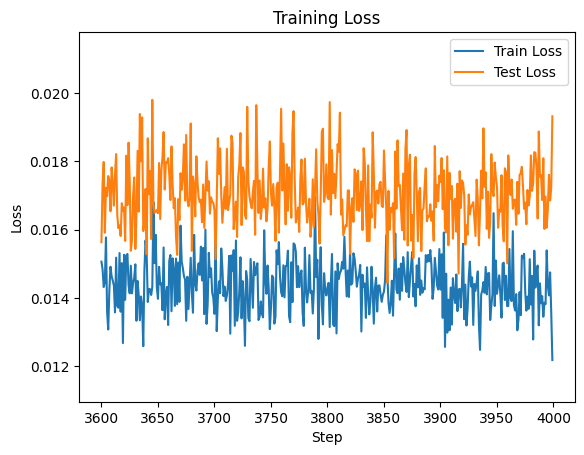

In [272]:
batch_size = 8

for i in tqdm(range(1000)):
    indices_train_list = []
    y_true_train_list = []
    indices_test_list = []
    y_true_test_list = []
    for b in range(batch_size):
        idx = np.random.randint(0, 900)
        text = ds["train"][idx]["text"]
        length = len(text)
        start = np.random.randint(0, length - max_seq_len)
        chunk = text[start:start + max_seq_len]
        indices = tokenizer.tokenize(chunk)

        y_true = tf.one_hot(indices, depth=tokenizer.vocab_size)
        y_true = tf.cast(y_true, tf.float32)

        indices_train_list.append(indices)
        y_true_train_list.append(y_true)

        idx = np.random.randint(900, 1000)
        text = ds["train"][idx]["text"]
        length = len(text)
        start = np.random.randint(0, length - max_seq_len)
        chunk = text[start:start + max_seq_len]
        indices = tokenizer.tokenize(chunk)

        y_true = tf.one_hot(indices, depth=tokenizer.vocab_size)
        y_true = tf.cast(y_true, tf.float32)

        indices_test_list.append(indices)
        y_true_test_list.append(y_true)
    
    
    loss_train = transformer.train_step(indices_train_list, y_true_train_list)
    loss_test = transformer.train_step(indices_test_list, y_true_test_list, update = False)
    
    losses_train.append(loss_train)
    losses_test.append(loss_test)

    clear_output(wait=True)
    x = np.arange(max(0, len(losses_train)-400), len(losses_train))
    plt.plot(x, losses_train[-400:], label="Train Loss")
    plt.plot(x, losses_test[-400:], label="Test Loss")

    plt.ylim(0.9*np.min(losses_train[-400:] + losses_test[-400:]), 1.1*np.max(losses_train[-400:] + losses_test[-400:]))
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

In [273]:
idx = np.random.randint(0, 1)
text = ds["train"][idx]["text"]

print(text)

One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.


In [274]:
text = 'One day, '
indices = tokenizer.tokenize(text)
print(indices.numpy())

[31 56 47  1 46 43 67  6  1]


In [275]:
for i in range(128):
    y_pred = transformer.pred(indices)
    argmax = tf.cast(tf.argmax(y_pred[-1], axis=-1), dtype=tf.int32)
    indices = tf.concat([indices, [argmax]], axis=0)
    #print(indices)
    text_pred = tokenizer.detokenize(indices)
    print(text_pred.numpy().decode("utf-8"), end='\r', flush=True)
    time.sleep(0.05)


In [199]:
print(tokenizer.vocab)
print(len(tokenizer.vocab))

['\n', ' ', '!', '"', '$', "'", ',', '-', '.', '0', '1', '3', '8', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'â', 'œ', '“', '”', '€', '™']
73


## 